In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import SimpleITK as sitk
import seaborn as sns
from collections import Counter
from kan import *
import torch

In [18]:
path = './REBL_features.csv'

In [4]:
df = pd.read_csv(path)
df.head()

,ID,Name,Label,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,wavelet-LLL_gldm_GrayLevelNonUniformity,wavelet-LLL_gldm_GrayLevelVariance,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
0,3,Infective_0003,1,v3.0.1,1.26.4,2.3.1,1.5.0,3.11.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4...",...,22314.578722,2.197220,113.724028,24.637758,2521.163263,0.242305,0.009226,0.289741,37.803348,0.002494
1,11,Infective_0011,1,v3.0.1,1.26.4,2.3.1,1.5.0,3.11.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4...",...,12515.937211,1.301105,166.326940,11.596806,1799.855085,0.075449,0.006246,0.392940,68.715383,0.002443
2,12,Infective_0012,1,v3.0.1,1.26.4,2.3.1,1.5.0,3.11.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4...",...,11541.673611,4.391676,224.402636,7.499221,1568.962443,0.036284,0.004704,0.459701,109.974710,0.002136
3,18,Infective_0018,1,v3.0.1,1.26.4,2.3.1,1.5.0,3.11.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4...",...,123901.383759,6.210063,307.318645,105.840619,30703.513563,0.365541,0.003430,0.076377,33.019661,0.000262
4,21,Infective_0021,1,v3.0.1,1.26.4,2.3.1,1.5.0,3.11.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4...",...,48803.638280,7.626201,192.896605,67.814350,11659.814870,0.397577,0.005828,0.125267,34.020956,0.000765


In [5]:
features = df.select_dtypes(include=[np.number]).drop(['Label'],axis = 1)
label = df.Label

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# StandardScaler
scaler = StandardScaler()
scaler.fit(features)
scaled_features = scaler.transform(features)

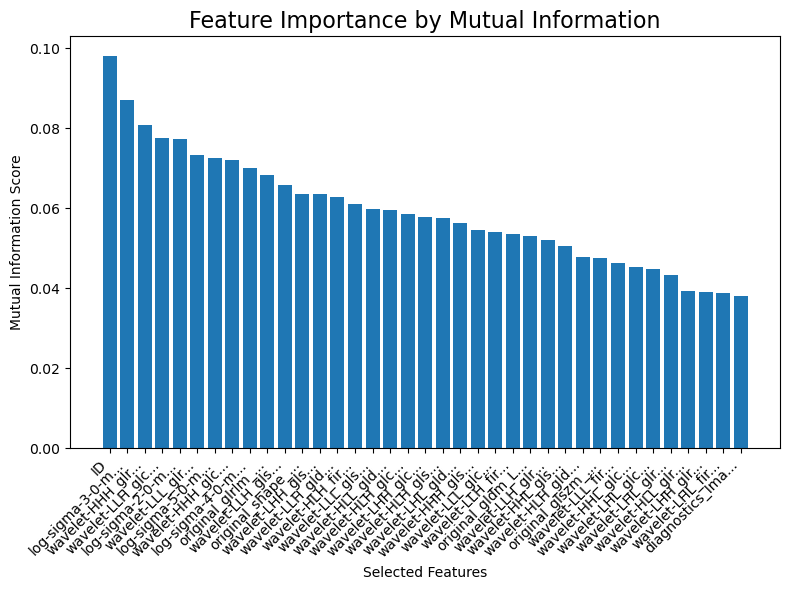

In [7]:
from sklearn.feature_selection import mutual_info_classif
# Mutual Information
n_features = 80
mi = mutual_info_classif(features, label)
feature_rankings = np.argsort(mi)[::-1]
selected_features = features.columns[feature_rankings[:n_features]]
mi_features = features[selected_features]

max_len = 15
truncated_features = [name[:max_len] + "..." if len(name) > max_len else name for name in selected_features]

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.bar(truncated_features, mi[feature_rankings[:n_features]])  # Extract top 80 MI scores
plt.xlabel("Selected Features")
plt.ylabel("Mutual Information Score")
plt.title("Feature Importance by Mutual Information", fontsize = 16)
plt.xticks(rotation=45, ha='right')  # Rotate feature names for readability
plt.tight_layout()
plt.show()

In [10]:
test = pd.read_csv('./REBL_features.csv')
test_features = test[selected_features]

In [11]:
test_features.to_csv(f'test_top{n_features}.csv')

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mi_features.values, label, test_size=0.3, random_state = 3)
print('Train shape %s' % Counter(y_train))
print('Validate shape %s' % Counter(y_test))
y_train = y_train.to_numpy()
y_train_b = np.zeros((y_train.size, y_train.max() + 1))
y_train_b[np.arange(y_train.size), y_train] = 1

y_test = y_test.to_numpy()
y_test_b = np.zeros((y_test.size, y_test.max() + 1))
y_test_b[np.arange(y_test.size), y_test] = 1

dataset = {
    'train_input': torch.from_numpy(X_train),
    'train_label': torch.from_numpy(y_train_b),
    'test_input': torch.from_numpy(X_test),
    'test_label': torch.from_numpy(y_test_b)
}

Train shape Counter({0: 97, 1: 17})
Validate shape Counter({0: 36, 1: 13})


In [84]:
def calc(y_test, y_pred):
    from sklearn.metrics import accuracy_score, classification_report, f1_score
    from sklearn.metrics import roc_curve, auc, confusion_matrix
    import matplotlib.pyplot as plt

    try:
        print(classification_report(y_test.cpu(),y_pred.cpu()))
        fpr, tpr, thresholds = roc_curve(y_test.cpu(), y_pred.cpu())
    except:
        print(classification_report(y_test,y_pred))
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
 
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap="Greys") 

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix", fontsize = 14)

    # Set ticks for labels
    tick_labels = ["Non-Infection", "Infection"]
    plt.xticks(range(len(tick_labels)), tick_labels, rotation=45)
    plt.yticks(range(len(tick_labels)), tick_labels)

    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, cm[i, j], ha="center", va="center", color = "Red", fontsize = 24)

    # plt.colorbar()

    plt.tight_layout()
    plt.show()
    return

In [92]:
# create a KAN
model = KAN(width=[n_features, 50, 100, 2], grid=15, k=3, seed=0)

In [93]:
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([114, 80]), torch.Size([114, 2]))

In [ ]:
model.train(dataset, opt="LBFGS", steps=20)

train loss: 3.43e+05 | test loss: 1.60e+06 | reg: 8.39e+02 :   5%|▏  | 1/20 [01:20<25:24, 80.23s/it]

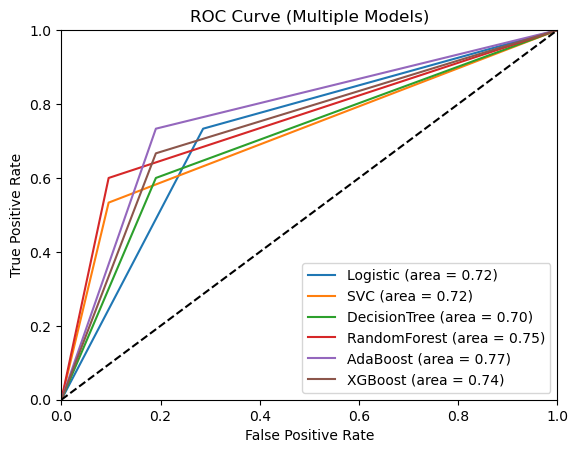

In [190]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have predictions (y_pred) for different models (e.g., logistics, svm, xgb)
models = ["Logistic", "SVC", "DecisionTree", "RandomForest", "AdaBoost", "XGBoost"]  # Replace with actual model names
y_true = y_test  # Assuming y_test is the ground truth labels

# Initialize variables to store AUC scores
all_fpr = []
all_tpr = []
all_auc = []

# Calculate ROC curves and AUC for each model
for model_name, y_pred in zip(models, [y_logis, y_svm, y_tree, y_rf, y_ada, y_xgb]):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves
plt.figure()
for i, (model_name, fpr, tpr, auc_score) in enumerate(zip(models, all_fpr, all_tpr, all_auc)):
    plt.plot(fpr, tpr, label=f'{model_name} (area = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiple Models)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)